# Pre-process Bengali hate-speech
This notebook does all the pre-processing on the Bengali hate-speech data, including:
- Removing user-tagging,
- Removing stopwords,
- Removing punctuations,
- Removing urls from text,
- Forming phrases,

### Input:
    Sample train and test data (with similar size and distribution as in Hindi dataset)
### Output:
    csv-files containing the ready-to-train data

# Import libraries

In [1]:
# Imports
import re
import string
import json
from datetime import datetime
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

device = 'cpu'

import random

random.seed(26)
np.random.seed(62)

## Load data

In [2]:
bengali_train_df = pd.read_csv('../data/bengali_hatespeech_sample_train.csv')
bengali_test_df = pd.read_csv('../data/bengali_hatespeech_sample_test.csv')

In [3]:
train_sentences = bengali_train_df['sentence']
test_sentences = bengali_test_df['sentence']

## Clean texts

In [4]:
# remove user taggings
user_tag_pattern = re.compile(r'\@\w*')
def remove_tagging(sentence):
    return re.sub(user_tag_pattern, ' ', sentence)

# remove punctuations and urls
http_re = re.compile('http://[^ ]*')
https_re = re.compile('https://[^ ]*')
punctuation = string.punctuation[:2] + string.punctuation[3:]
translator = str.maketrans(punctuation, ' '*len(punctuation))
def remove_punc_and_urls(s):
    s = re.sub(http_re, ' ', s)
    s = re.sub(https_re, ' ', s)
    s = s.translate(translator)
    return s

# substitute numbers
#   when there is a number in the string:
#   if that number is 0 or 1 or 2, then there is no change.
#   else, that number is substituted by a word describing how many digits it has.
def substitute_number(x):
    x = x.group(0)
    if x in {'0', '1', '2'}:
        return x
    return '{}_digits_number'.format(len(x))

# stopwords BENGALI (source: https://www.ranks.nl/stopwords/bengali)
stopwords = ['অবশ্য', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অথবা', 'অথচ', 'অর্থাত', 'অন্য', 'আজ', 'আছে', 'আপনার', 
             'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আরও', 'আর', 'আগে', 'আগেই', 'আই', 
             'অতএব', 'আগামী', 'অবধি', 'অনুযায়ী', 'আদ্যভাগে', 'এই', 'একই', 'একে', 'একটি', 'এখন', 'এখনও', 'এখানে', 
             'এখানেই', 'এটি', 'এটা', 'এটাই', 'এতটাই', 'এবং', 'একবার', 'এবার', 'এদের', 'এঁদের', 'এমন', 'এমনকী', 'এল', 
             'এর', 'এরা', 'এঁরা', 'এস', 'এত', 'এতে', 'এসে', 'একে', 'এ', 'ঐ', ' ই', 'ইহা', 'ইত্যাদি', 'উনি', 'উপর', 
             'উপরে', 'উচিত', 'ও', 'ওই', 'ওর', 'ওরা', 'ওঁর', 'ওঁরা', 'ওকে', 'ওদের', 'ওঁদের', 'ওখানে', 'কত', 'কবে', 
             'করতে', 'কয়েক', 'কয়েকটি', 'করবে', 'করলেন', 'করার', 'কারও', 'করা', 'করি', 'করিয়ে', 'করার', 'করাই', 
             'করলে', 'করলেন', 'করিতে', 'করিয়া', 'করেছিলেন', 'করছে', 'করছেন', 'করেছেন', 'করেছে', 'করেন', 'করবেন', 
             'করায়', 'করে', 'করেই', 'কাছ', 'কাছে', 'কাজে', 'কারণ', 'কিছু', 'কিছুই', 'কিন্তু', 'কিংবা', 'কি', 'কী', 'কেউ', 
             'কেউই', 'কাউকে', 'কেন', 'কে', 'কোনও', 'কোনো', 'কোন', 'কখনও', 'ক্ষেত্রে', 'খুব	গুলি', 'গিয়ে', 'গিয়েছে', 
             'গেছে', 'গেল', 'গেলে', 'গোটা', 'চলে', 'ছাড়া', 'ছাড়াও', 'ছিলেন', 'ছিল', 'জন্য', 'জানা', 'ঠিক', 'তিনি', 
             'তিনঐ', 'তিনিও', 'তখন', 'তবে', 'তবু', 'তাঁদের', 'তাঁাহারা', 'তাঁরা', 'তাঁর', 'তাঁকে', 'তাই', 'তেমন', 'তাকে', 
             'তাহা', 'তাহাতে', 'তাহার', 'তাদের', 'তারপর', 'তারা', 'তারৈ', 'তার', 'তাহলে', 'তিনি', 'তা', 'তাও', 'তাতে', 
             'তো', 'তত', 'তুমি', 'তোমার', 'তথা', 'থাকে', 'থাকা', 'থাকায়', 'থেকে', 'থেকেও', 'থাকবে', 'থাকেন', 'থাকবেন', 
             'থেকেই', 'দিকে', 'দিতে', 'দিয়ে', 'দিয়েছে', 'দিয়েছেন', 'দিলেন', 'দু', 'দুটি', 'দুটো', 'দেয়', 'দেওয়া', 'দেওয়ার', 
             'দেখা', 'দেখে', 'দেখতে', 'দ্বারা', 'ধরে', 'ধরা', 'নয়', 'নানা', 'না', 'নাকি', 'নাগাদ', 'নিতে', 'নিজে', 'নিজেই', 
             'নিজের', 'নিজেদের', 'নিয়ে', 'নেওয়া', 'নেওয়ার', 'নেই', 'নাই', 'পক্ষে', 'পর্যন্ত', 'পাওয়া', 'পারেন', 'পারি', 'পারে', 
             'পরে', 'পরেই', 'পরেও', 'পর', 'পেয়ে', 'প্রতি', 'প্রভৃতি', 'প্রায়', 'ফের', 'ফলে', 'ফিরে', 'ব্যবহার', 'বলতে', 
             'বললেন', 'বলেছেন', 'বলল', 'বলা', 'বলেন', 'বলে', 'বহু', 'বসে', 'বার', 'বা', 'বিনা', 'বরং', 'বদলে', 'বাদে', 
             'বার', 'বিশেষ', 'বিভিন্ন	বিষয়টি', 'ব্যবহার', 'ব্যাপারে', 'ভাবে', 'ভাবেই', 'মধ্যে', 'মধ্যেই', 'মধ্যেও', 'মধ্যভাগে', 
             'মাধ্যমে', 'মাত্র', 'মতো', 'মতোই', 'মোটেই', 'যখন', 'যদি', 'যদিও', 'যাবে', 'যায়', 'যাকে', 'যাওয়া', 'যাওয়ার', 
             'যত', 'যতটা', 'যা', 'যার', 'যারা', 'যাঁর', 'যাঁরা', 'যাদের', 'যান', 'যাচ্ছে', 'যেতে', 'যাতে', 'যেন', 'যেমন', 
             'যেখানে', 'যিনি', 'যে', 'রেখে', 'রাখা', 'রয়েছে', 'রকম', 'শুধু', 'সঙ্গে', 'সঙ্গেও', 'সমস্ত', 'সব', 'সবার', 'সহ', 
             'সুতরাং', 'সহিত', 'সেই', 'সেটা', 'সেটি', 'সেটাই', 'সেটাও', 'সম্প্রতি', 'সেখান', 'সেখানে', 'সে', 'স্পষ্ট', 'স্বয়ং', 
             'হইতে', 'হইবে', 'হৈলে', 'হইয়া', 'হচ্ছে', 'হত', 'হতে', 'হতেই', 'হবে', 'হবেন', 'হয়েছিল', 'হয়েছে', 'হয়েছেন', 'হয়ে', 
             'হয়নি', 'হয়', 'হয়েই', 'হয়তো', 'হল', 'হলে', 'হলেই', 'হলেও', 'হলো', 'হিসাবে', 'হওয়া', 'হওয়ার', 'হওয়ায়', 'হন', 
             'হোক', 'জন', 'জনকে', 'জনের', 'জানতে', 'জানায়', 'জানিয়ে', 'জানানো', 'জানিয়েছে', 'জন্য', 'জন্যওজে', 'জে', 
             'বেশ', 'দেন', 'তুলে', 'ছিলেন', 'চান', 'চায়', 'চেয়ে', 'মোট', 'যথেষ্ট', 'টি']



In [5]:
def clean_texts(sentences):
    # tags
    sentences = [remove_tagging(sentence) for sentence in sentences]
    
    # lower case
    sentences = [sentence.lower() for sentence in sentences]
    
    # remove punctuations and urls 
    sentences = [remove_punc_and_urls(sentence) for sentence in sentences]
    
    # substitute numbers
    sentences = [re.sub('\\b[0-9]+\\b', substitute_number, sentence) for sentence in sentences]
    
    # remove stopwords
    sentences = [[word for word in sentence.split() if word not in stopwords] for sentence in sentences]
    
    return sentences

In [6]:
# perform cleaning

train_sentences = clean_texts(train_sentences)
train_texts = [' '.join(l) for l in train_sentences]
bengali_train_df['sentence'] = train_texts

test_sentences = clean_texts(test_sentences)
test_texts = [' '.join(l) for l in test_sentences]
bengali_test_df['sentence'] = test_texts

In [7]:
# exclude empty sentences
bengali_train_df = bengali_train_df[bengali_train_df['sentence'].str.len() != 0].reset_index(drop=True)
bengali_test_df = bengali_test_df[bengali_test_df['sentence'].str.len() != 0].reset_index(drop=True)

In [8]:
bengali_train_df['sentence'][2057]

'ডেট লিখছি দেখেন ত মিল পান কিনা may 2_digits_number শুক্রবার রাজাকার আলোকচিত্র may 2_digits_number শুক্রবার টুকিটাকি ভাবনা june 2_digits_number শুক্রবার সমন্বিত ভর্তি পরীক্ষা june 2_digits_number শুক্রবার ক্ষমতা অধিকার july 2_digits_number শুক্রবার ওয়ার্ল্ড কাপ july 2_digits_number শুক্রবার গণিত অলিম্পিয়াড august 2_digits_number শুক্রবার মৃত্যুর উপত্যকা গত মে মাস জাফর ইকবার স্যার লেখা প্রকাশের তারিখ।কি অদ্ভত মিল মিলের কারন লেখেন একটা পত্রিকায়।শুক্রবার সংখ্যা মাসে দুই বার।তিনি মত মন চাইল সাথে সাথে পোষ্ট করলাম ফেসবুকে।এটাও জানার বিষয় ফেবু আইডি নাই।😅😅একটা পেজ ভেরিফায়েড ডিপার্টমেন্ট বড় ভাইয়ে রা চালায়। বাংলাদেশ international math olympiad সোনা জিতল 2_digits_number july ।যেই লোকটা ম্যাথ অলিম্পিয়াড শুরু করল বাংলাদেশে প্রতিক্রিয়া আসল ০৬ দিন কারন লেখাটা লিখছিলেন বাট পত্রিকায় টাইমলি পাব্লিশ ০৬ দিন লেগে যায়।এদিকে সবাই ইসটেটাস ভরে ফেলছিলাম।মনে 😂😂 মৃত্যুর উপত্যকা লেখা টা লিখেছিলেম ০১ আগস্ট ভেরিফায়েড পেজ নিচে ডেট পাব্লিশ ডেট ০৩ আগস্ট ১২ঃ০০ পত্রিকাটির অনলাইন সংস্করন বের হয়ার সাথে সাথে গায়েবি জানাজা প

## Form phrases

some most-common 2-grams:
[(('কুত্তার', 'বাচ্চা'), 69), (('লুচ্চা', 'লুচ্চা'), 55), (('খানকির', 'পোলা'), 38), (('ফাঁসি', 'চাই'), 29), (('তুই', 'একটা'), 29)]


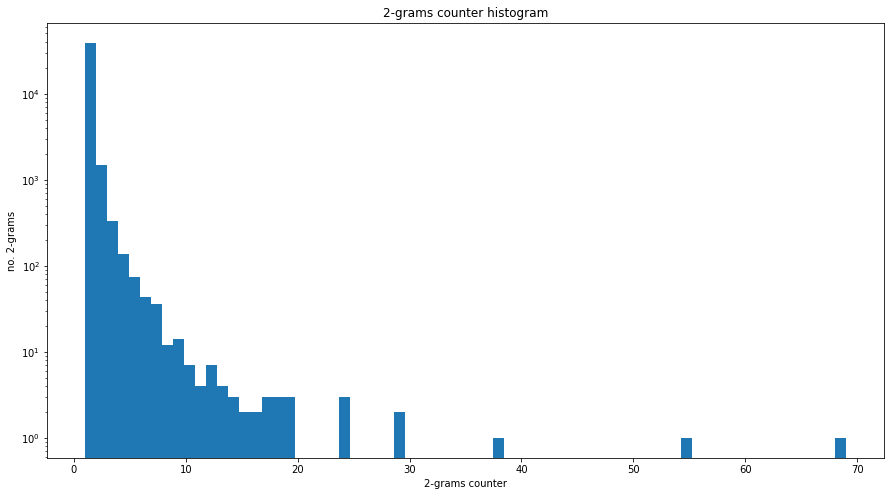

In [9]:
# count 2-grams
two_grams = []
for sentence in bengali_train_df['sentence']:
    words = sentence.split()
    two_grams.extend([(words[i], words[i+1]) for i in range(len(words)-1)])

gram_counter = Counter(two_grams)
print('some most-common 2-grams:')
print(gram_counter.most_common(5))

# plot 2-gram frequencies
fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(gram_counter.values(), bins=gram_counter.most_common(1)[0][1])
ax.set_title('2-grams counter histogram')
ax.set_xlabel('2-grams counter')
ax.set_ylabel('no. 2-grams')
ax.set_yscale('log')

In [10]:
# at first, we choose threshold = 10, i.e. 2-grams that appear at least 10 times are considered phrases
# however, this doesn't increase accuracy. Maybe because the dataset is too small that statistic inferences are not sound.
# So, we disable 2-grams by setting threshold to 100, i.e. no 2-grams are formed.
two_grams_threshold_occurences = 100

phrases = [grams for grams in gram_counter if gram_counter[grams] >= two_grams_threshold_occurences]

## Vocab and Word <-> int transformation

In [11]:
def split_sentence(sentence):
    words = sentence.split()
    splitted = []
    i = 0
    while i < len(words):
        if (i < len(words) - 1 and (words[i], words[i+1]) in phrases):
            splitted.append('_'.join((words[i], words[i+1])))
            i += 2
        else:
            splitted.append(words[i])
            i += 1
    
    return splitted

train_sentences = [split_sentence(sentence) for sentence in bengali_train_df['sentence']]
test_sentences = [split_sentence(sentence) for sentence in bengali_test_df['sentence']]

flattened_words = [word for sentence in train_sentences for word in sentence]
V = list(set(flattened_words))
vocab_size = len(V)
print(f'vocab_size: {vocab_size}')

word_to_int = {}
int_to_word = {}
for i, word in enumerate(V):
    word_to_int[word] = i
    int_to_word[i] = word

# save dicts for transformation word <-> int
with open('save/word_to_int_dict.json', 'w') as f:
    json.dump(word_to_int, f)
with open('save/int_to_word_dict.json', 'w') as f:
    json.dump(int_to_word, f)    

# save word-counter for sampling
word_counter = Counter(flattened_words)
with open('save/word_counter.json', 'w') as f:
    json.dump(word_counter, f)

vocab_size: 15983


In [12]:
train_sentences = [[word_to_int[word] for word in sentence] for sentence in train_sentences]
test_sentences = [[word_to_int[word] for word in sentence if word in word_to_int] for sentence in test_sentences]

In [13]:
# exclude empty sentences

train_texts = [' '.join([str(v) for v in l]) for l in train_sentences]
bengali_train_df['sentence'] = train_texts
bengali_train_df = bengali_train_df[bengali_train_df['sentence'].str.len() != 0].reset_index(drop=True)

test_texts = [' '.join([str(v) for v in l]) for l in test_sentences]
bengali_test_df['sentence'] = test_texts
bengali_test_df = bengali_test_df[bengali_test_df['sentence'].str.len() != 0].reset_index(drop=True)

## Save output

In [14]:
display(bengali_train_df.head())
display(bengali_test_df.head())

,sentence,hate,category
0,12431 11321 507 13590 993 8990 7341 7078,0,religion
1,9604 9604,0,"Meme, TikTok and others"
2,3670 1156 7483 2177 6216 10707 10178 12322 116...,0,crime
3,12223 9092 15432 9238,0,sports
4,14827 741 6632 4244 6006 227 14522 11471 227 1...,0,entertainment


,sentence,hate,category
0,5664 10661 3793 6014,0,celebrity
1,7078 7570 3439 15021,0,sports
2,14440 12714,1,entertainment
3,26 13983 4331 7138,1,politics
4,11205 10335 8298 9150,1,entertainment


In [15]:
bengali_train_df.to_csv('save/bengali_train_preprocessed.csv', index=False)
bengali_test_df.to_csv('save/bengali_test_preprocessed.csv', index=False)